In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
train_data = pd.read_csv('../input/titanic/train.csv')
test_data = pd.read_csv('../input/titanic/test.csv')

In [ ]:
train_data.shape

In [ ]:
#returns a dataframe with only entries that have a null values in a particular field
def null_entries(field):
    null_values = train_data[[field]].isnull()
    null_values = null_values[null_values[field] == True]
    return null_values

In [ ]:
print(null_entries('Embarked'))

In [ ]:
train_data.dtypes

In [ ]:
train_data.describe()

In [ ]:
import seaborn as sns
sns.barplot(x=train_data['Survived'],y = train_data['Age'],hue = train_data['Pclass'])

In [4]:
#model imports
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, learning_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
import matplotlib.pyplot as plt

In [17]:
def valid_curve(model, x,y, folds,pname, plist):
   # print(x.shape)
    #print(y.shape)
    train_score, valid_score = validation_curve(model, x, y, cv = folds, scoring = 'accuracy',param_name=pname, param_range=plist)
   # print(train_score)
    #print(train_score.shape)
  #  print(valid_score.shape)
    train_means = np.mean(train_score, axis=1)
    #print(train_means)
   # print(train_means.shape)
    valid_means=np.mean(valid_score,axis=1)
    plt.plot(plist, train_means, label = "Training Accuracy", color = 'b')
    plt.plot(plist, valid_means, label = "Validation Accuracy", color = 'g')
    plt.legend(loc = 'best')
    plt.title('Validation Curve')
    plt.xlabel(pname)
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()
def learn_curve(model, x, y, folds=5, size_list=[100,200,300,400,500,600]):
    tsizes,train_score, valid_score = learning_curve(model, x, y,train_sizes = size_list)
   # print(tsizes)
    train_means = np.mean(train_score, axis = 1)
    valid_means = np.mean(valid_score, axis = 1)
   # print(train_means)
    #print(valid_means)
    plt.plot(tsizes, train_means, label = "Training Accuracy", color = 'b')
    plt.plot(tsizes, valid_means, label = "Validation Accuracy", color = 'g')
    plt.legend(loc = 'best')
    plt.title('Learning Curve as accuracy over training sample size')
    plt.xlabel('Training samples')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()
    

In [5]:
#data splitting and processing
y = train_data['Survived']
x = train_data.copy()
x = x.drop(['Survived'], axis = 1)
print(x.dtypes)
print(y.dtypes)
x_train, x_valid, y_train, y_valid = train_test_split(x,y,test_size = 0.3)

print(f'x train shape {x_train.shape}')
print(f'x valid shape {x_valid.shape}')
print(f'y train shape {y_train.shape}')
print(f'y valid shape {y_valid.shape}')

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
int64
x train shape (623, 11)
x valid shape (268, 11)
y train shape (623,)
y valid shape (268,)


In [ ]:
cat_columns = [c for c in x.columns if x.dtypes[c] == object]
print(cat_columns)

In [6]:
#defining pipelines
cat_encoding = OneHotEncoder(handle_unknown = 'ignore')
age_imputer = SimpleImputer(strategy = 'mean')
cabin_imputer = SimpleImputer(strategy = 'constant', fill_value = 'NaN')
embarked_imputer = SimpleImputer(strategy = 'constant', fill_value = 'None')

cabin_pipeline = Pipeline(steps=[('cabimp', cabin_imputer),('cabhot', cat_encoding)])
embarked_pipeline = Pipeline(steps=[('embimp', embarked_imputer),('embhot', cat_encoding)])

cat_columns = ['Name','Sex','Ticket']
#cat_columns = [c for c in x.columns if x.dtypes[c] == object]
trans = ColumnTransformer(transformers = [('age', age_imputer, ['Age']),('cabin', cabin_pipeline, ['Cabin']), ('embarked', embarked_pipeline, ['Embarked']), ('onehot', cat_encoding, cat_columns)])

In [ ]:
import sklearn
print(sklearn.metrics.get_scorer_names())

In [10]:
model = RandomForestClassifier(n_estimators = 10)
pipe = Pipeline(steps = [('pre', trans), ('model', model)])

score = cross_val_score(pipe, X = x, y = y, cv = 5, scoring= 'accuracy')
print(score.mean())

0.8069487163392128


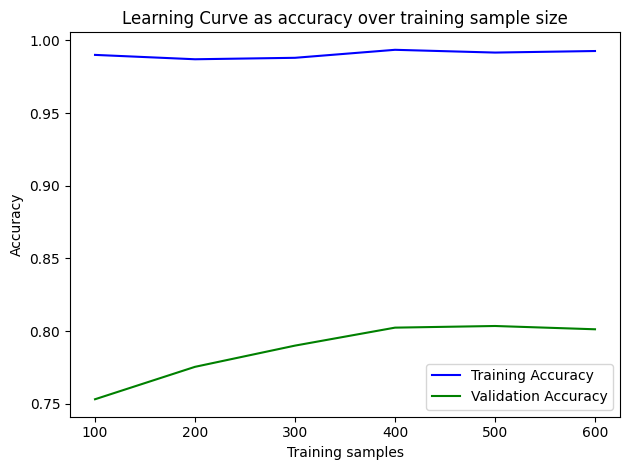

In [11]:
model = RandomForestClassifier(n_estimators = 20)
pipe = Pipeline(steps = [('pre', trans), ('model', model)])
learn_curve(pipe, x, y, folds = 5,size_list = [100,200,300,400,500,600])

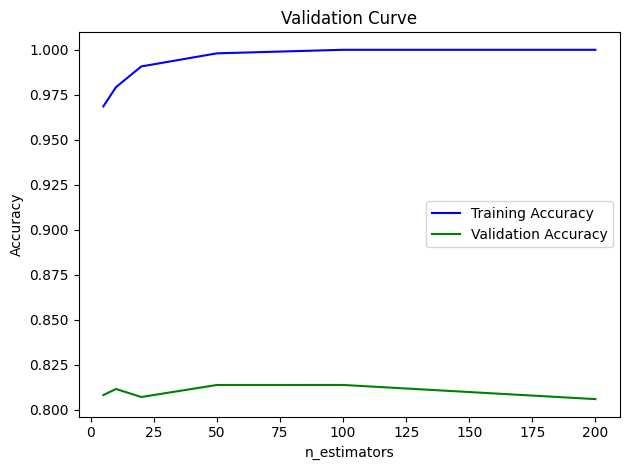

In [12]:
mod = RandomForestClassifier()
encoded_x = trans.fit_transform(x)
#pipe = Pipeline(steps = [('pre', trans), ('model', mod)])
valid_curve(mod, encoded_x, y, folds=5, pname='n_estimators',plist=[5,10,20,50,100,200])

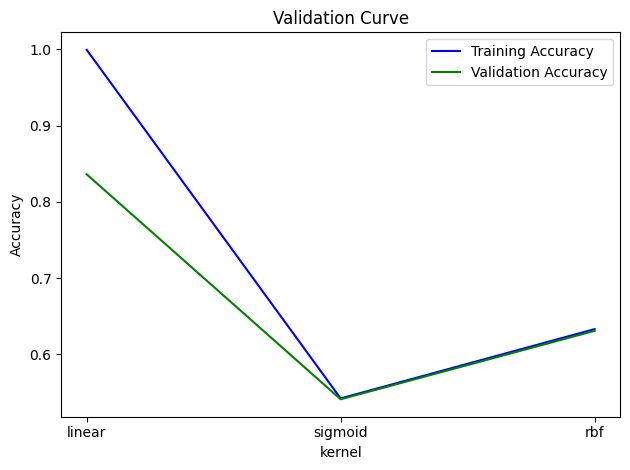

In [15]:
model = svm.SVC()
encoded_x = trans.fit_transform(x)
valid_curve(model, encoded_x, y, folds=5,pname = 'kernel', plist=['linear','sigmoid','rbf','polynomial'])

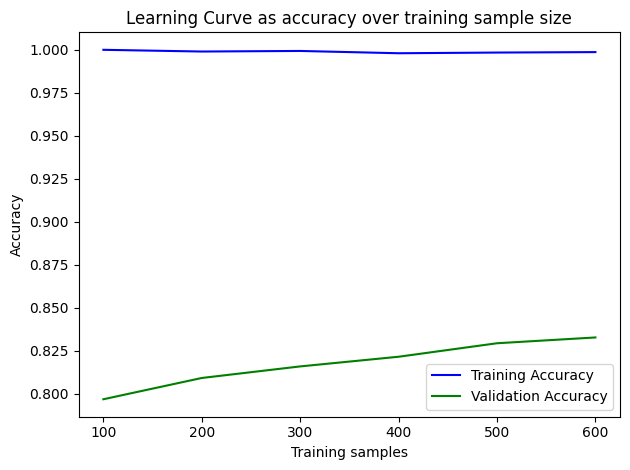

0.8361182599962337


In [19]:
model = svm.SVC(kernel='linear')
pipe = Pipeline(steps = [('pre', trans), ('model', model)])
learn_curve(pipe, x, y)
score = cross_val_score(pipe, X = x, y = y, cv = 5, scoring= 'accuracy')
print(score.mean())

PassengerId    0.665912
Name           0.665912
Ticket         0.572496
Cabin          0.165236
Sex            0.150870
Fare           0.147134
Pclass         0.058107
SibSp          0.023197
Age            0.020499
Embarked       0.016668
Parch          0.016366
Name: MI scores, dtype: float64


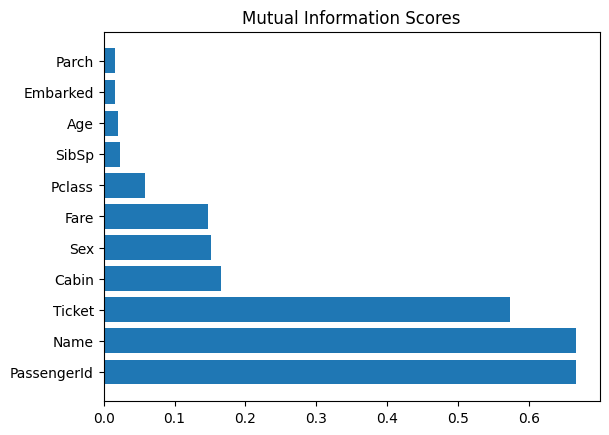

<Figure size 800x500 with 0 Axes>

In [42]:
#mutual info
from sklearn.feature_selection import mutual_info_classif

def plot_mi(scores):
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
    plt.figure(dpi=100, figsize = (8,5))
    plt.show()

x2 = x.copy()

age_imputer = SimpleImputer(strategy = 'mean')
x2['Age'] = age_imputer.fit_transform(pd.DataFrame(x2['Age']))

for c in x2.select_dtypes("object"):
    x2[c], _ = x2[c].factorize()
    
disc_feats = x2.dtypes == int

scores = mutual_info_classif(x2,y, discrete_features=disc_feats)
scores = pd.Series(scores,name = "MI scores", index = x2.columns)
scores = scores.sort_values(ascending=False)

print(scores)
plot_mi(scores)